In [1]:
import sklearn
import os
# Common imports
import numpy as np
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "C:/Users/15517/python/机器学习实战"
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Projection methods
Build 3D dataset: 构造三维数据集

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))  # 60行3列
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2 # cosx + sinx / 2 + 噪音 + 随机数
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition 
主成分分析使用奇异值分解

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [4]:
m,n = X.shape

S = np.zeros(X_centered.shape)
S[:n,:n] = np.diag(s) # 提取对角线或构造对角线数组

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt)) #如果两个数组在一个容忍范围内元素相等，则返回True。

True

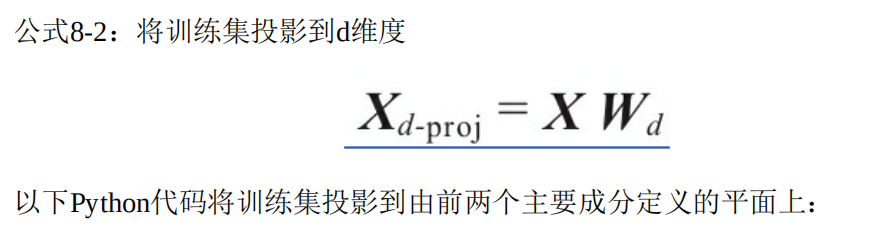

In [6]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

## PCA using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

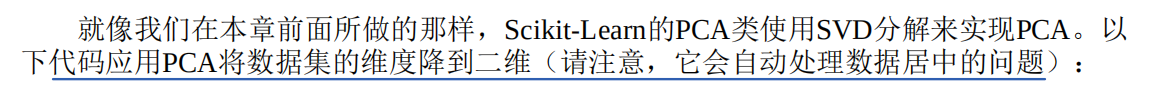

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5] # 使用的Sklearn方法

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]  # 使用SVC奇异值分解

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

请注意，在稍有不同的数据集上多次运行PCA可能会导致不同的结果。一般来说，唯一的区别是某些轴可能会翻转。在这个例子中，使用Scikit-Learn的PCA给出了与SVD方法给出的相同的投影，除了两个轴翻转: 正负值不同

In [11]:
np.allclose(X2D, -X2D_using_svd) # 如果两个数组在一个容忍范围内元素相等，则返回True。

True

恢复投影在平面上的三维点(PCA 2D子空间)。

In [12]:
X3D_inv = pca.inverse_transform(X2D) #将数据转换回原始空间  Sklearn方法

当然，在投影步骤中会有一些信息的丢失，所以恢复的三维点并不完全等于原始的三维点:

In [13]:
np.allclose(X3D_inv, X) 

False

我们可以计算重构误差:

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1)) 

0.010170337792848549

SVD方法中的反变换是这样的:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])  # SVD方法

这两种方法的重建是不相同的，因为Scikit-Learn的 `PCA` 类自动处理反转均值中心，但如果我们减去均值，我们得到相同的重建:

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_) # SVD方法和Sklearn方法-pca.mean_ 在容忍范围内相等

True

`PCA `对象允许访问它计算的主要组件

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

与SVD方法计算的前两个主成分比较:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

注意坐标轴是如何翻转的。

现在让我们看看被解释的方差比:

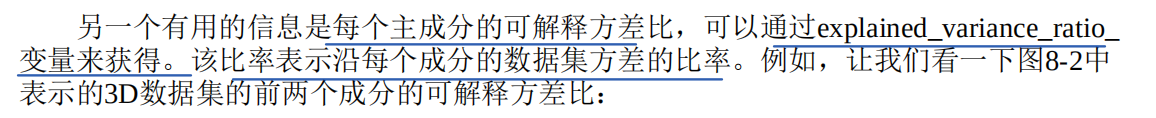

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

第一个维度解释了84.2%的方差，而第二个维度解释了14.6%。

通过投影到2D，我们损失了1.1%的方差:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

下面是如何使用SVD方法计算被解释方差比(回想一下s是矩阵`S`的对角线):

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

# PCA
# 主成分分析

Saving figure pca_best_projection_plot


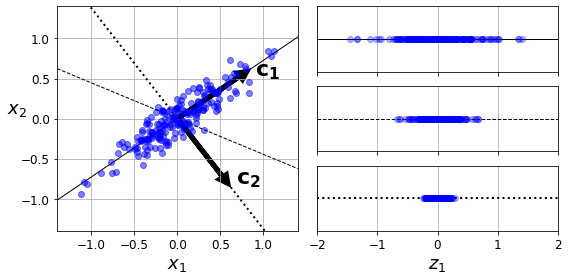

In [22]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

# MNIST compression

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [24]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

## 选择正确的维度

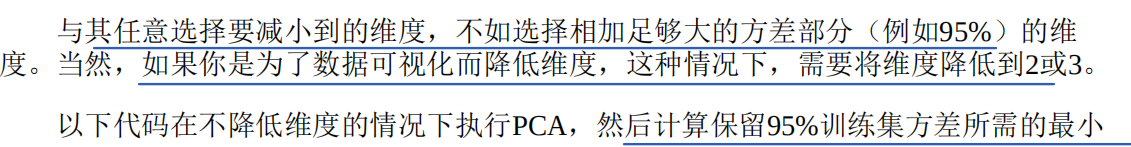

In [25]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [26]:
d

154

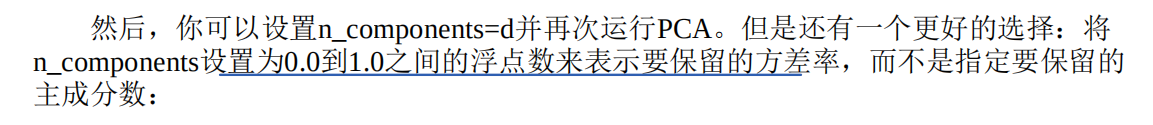

In [27]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [28]:
pca.n_components_

154

In [29]:
# 查看被解释方差比
np.sum(pca.explained_variance_ratio_)

0.9504334914295711

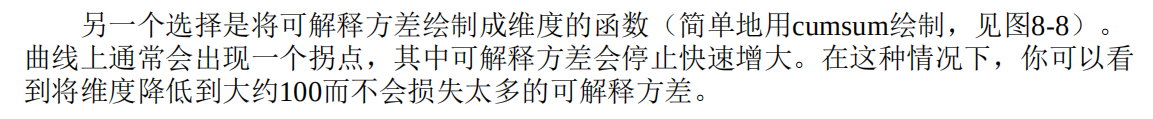

Saving figure explained_variance_plot


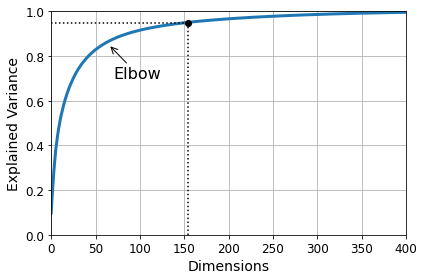

In [30]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:") # 画条线 (154,0) 到54,0.95)
plt.plot([0, d], [0.95, 0.95], "k:") # (0,0.95)到(154,0.95)
plt.plot(d, 0.95, "ko") # 画个点(154,0.95) 
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

### 8.3.7 PCA 压缩


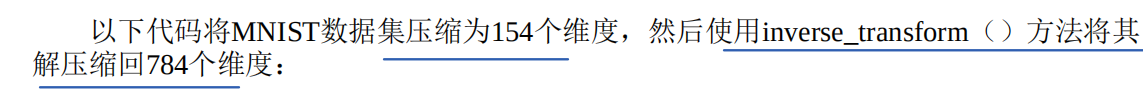

In [31]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train) # 压缩
X_recovered = pca.inverse_transform(X_reduced) # 解压缩回

In [32]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


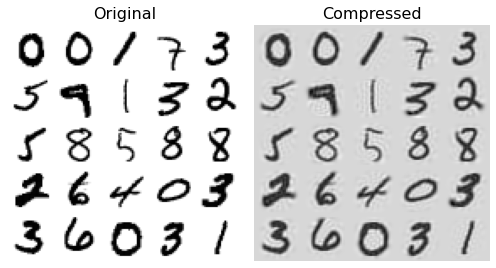

In [33]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100]) # 原始数据
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100]) # 解压缩回数据
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [34]:
X_reduced_pca = X_reduced

## Incremental PCA
## 增量PCA

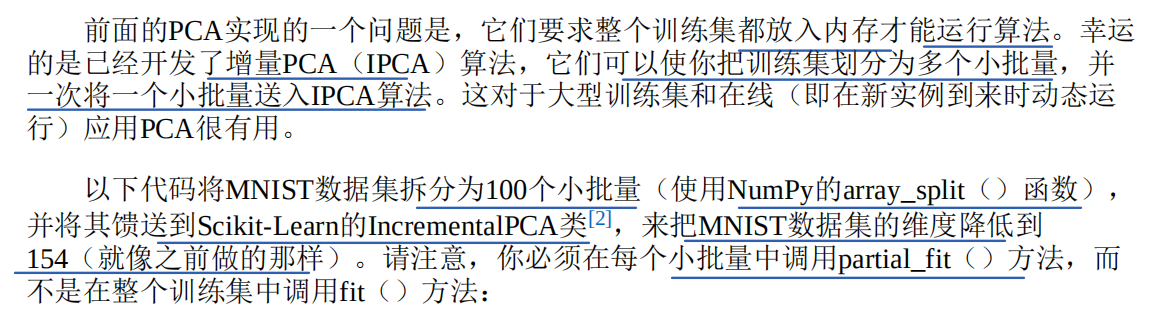

In [35]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100  #小批量
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train,n_batches):
    print('.',end='')  
    inc_pca.partial_fit(X_batch)  # 小批量训练

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [36]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)  # 增量PCA解压缩回

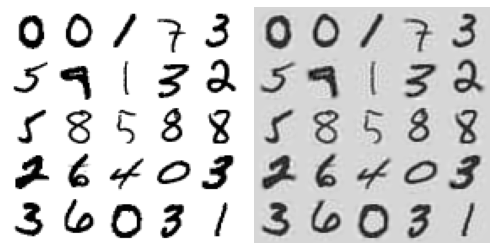

In [37]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [38]:
X_reduced_inc_pca = X_reduced

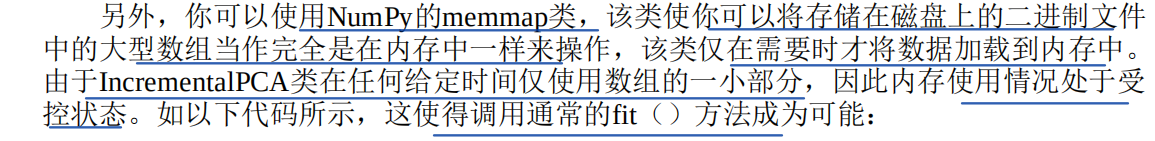

让我们比较一下使用常规PCA和增量PCA对MNIST进行转换的结果。首先，手段是平等的:

In [39]:
np.allclose(pca.mean_, inc_pca.mean_)

True

但结果并不完全相同。增量PCA给出了一个非常好的近似解，但它不是完美的:

In [40]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Using memmap()

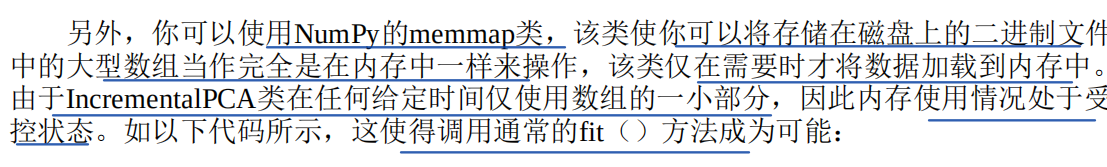

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [41]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

现在删除memmap()对象将触发它的Python终结器，这将确保数据保存到磁盘。

In [42]:
del X_mm

接下来，另一个程序将加载数据并用于训练:

In [43]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

In [44]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Time complexity

让我们对不同数量的主成分进行常规主成分分析与增量主成分分析和随机主成分分析:

In [45]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")  # 常规PCA
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500) # 增量PCA
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized") # 随机PCA

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 20.3 seconds
    Inc PCA: 38.6 seconds
    Rnd PCA: 2.6 seconds
n_components = 10
    PCA: 17.6 seconds
    Inc PCA: 37.9 seconds
    Rnd PCA: 7.8 seconds
n_components = 154
    PCA: 22.8 seconds
    Inc PCA: 46.0 seconds
    Rnd PCA: 16.3 seconds


现在让我们比较不同大小(实例数)的PCA和随机PCA:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

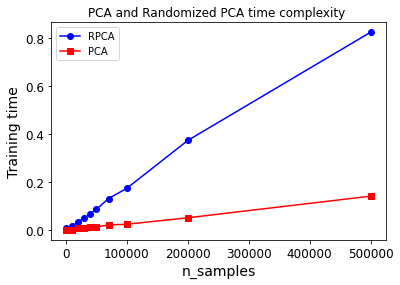

In [46]:
times_rpca = [] # 随机PCA
times_pca = [] # 常规PCA
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]  #规模大小
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42) # 随机PCA 主成分为2
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full") # 常规PCA 主成分为2
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

现在让我们比较一下它们在2000个实例的不同特征数据集上的性能:

......

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

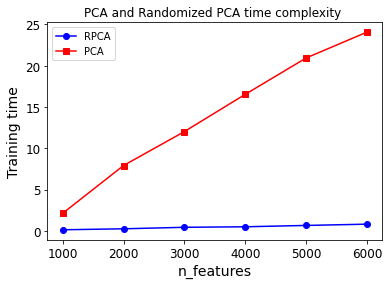

In [47]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)
    print('.',end = '')

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

### 随机PCA在实例数量比较小的时候训练速度更快，随着数据的增大 训练速度会降低

## 8.4 内核PCA

In [52]:
from sklearn.datasets import make_swiss_roll

In [53]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [54]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

Saving figure kernel_pca_plot


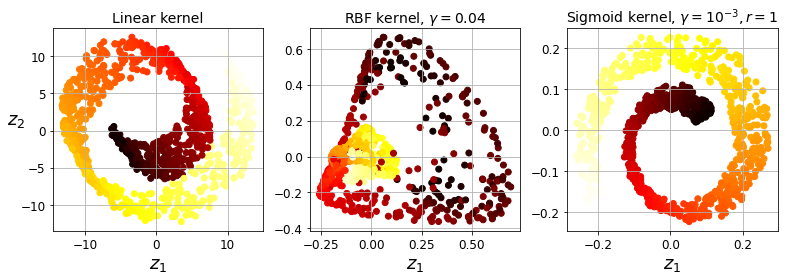

In [55]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) # 线性PCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) # RBF。PCA
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) # sigmoid.PCA

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

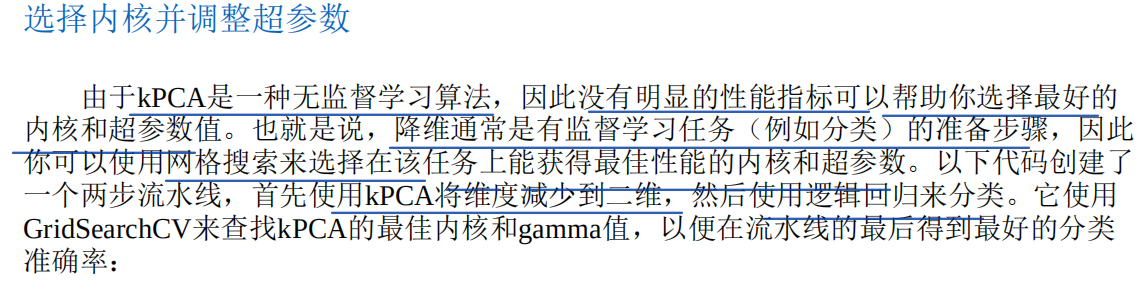

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

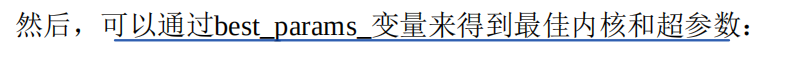

In [57]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [58]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [59]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

# LLE 局部线性嵌入

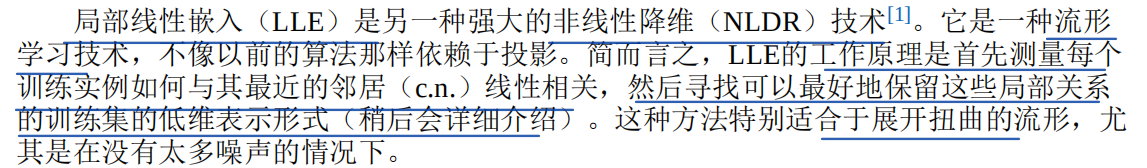

In [60]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [61]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


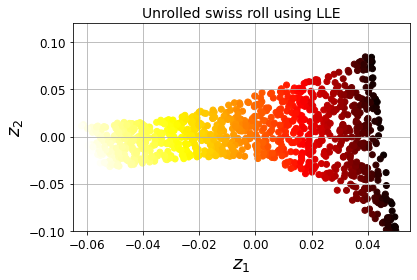

In [62]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

# 其他降维方法
# MDS, Isomap and t-SNE

In [63]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [64]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [66]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

Saving figure other_dim_reduction_plot


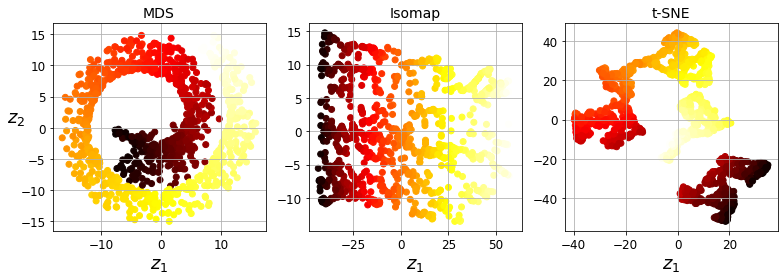

In [67]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()